# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

> The data task is to identify the correlation between parameters and vehicle price, or parameter weights of one or more (more) regression models that will similarly inform which parameters contribute most positively and negatively to car price.

> On data reduncancy: there are several columns that carry repeated information, such as {'state' and 'region'}, {'manufacturer' and 'model'}. It could be argued that all the information contained in 'state' is represented by 'region' and so 'state' may be dropped. Likewise, 'make' could be dropped. Dropping the redundant columns would reduce the dimensionality of the data, but would discard some information that may be directly relevant to the client. It's possible the client cares about a trend by state or manufacturer, and those trends can be read directly from the model if the redundant columns are retained.

### Utilities

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler, TargetEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector


warnings.filterwarnings('ignore')

In [43]:
# Utility to record model results
model_rmse_df = pd.DataFrame(columns = ['model_name', 'data_id', 'train_rmse', 'test_rmse'])

def record_results(model_name, data_id, train_rmse, test_rmse):
    model_rmse_df.loc[len(model_rmse_df)] = {
        'model_name': model_name,
        'data_id': data_id,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
}

In [54]:
def model_fit_evaluate(model, X_train, X_test, y_train, y_test, report=True, fit=True):
    if fit:
        model.fit(X_train, y_train)
    
    train_rmse = root_mean_squared_error(y_train, model.predict(X_train))
    test_rmse = root_mean_squared_error(y_test, model.predict(X_test))

    if report:
        print(f'  MSE (train/test): {train_rmse:.3f}, {test_rmse :.3f}')
    return (train_rmse, test_rmse)


In [4]:
# Utilities to save and load objects
#   Models that took hours to train, I'm looking at you!
import pickle

def save_object(obj, path):
    with open(path, 'wb') as file:
        pickle.dump(obj, file)

def load_object(path):
    with open('my_object.pkl', 'rb') as file:
        obj = pickle.load(file)
    return obj

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

* Import the data
* Explore the data
* Resolve missing data (fill with 'NA', most common value, or drop rows)

In [5]:
df = pd.read_csv('data/vehicles.csv')
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [6]:
# df.dropna().shape   # 34_868 down from 426_880.
# That's unacceptable loss. Need to look closer...

In [7]:
# Inspecting the data with DataWrangler shows...
# 1. Several columns are missing very little data. Rows with nulls in these columns can be dropped with minimal loss.
#   - 'year' (<1%)
#   - 'manufacturer' (4%)
#   - 'model' (1%)
#   - 'fuel' (1%)
#   - 'odometer' (1%)
#   - 'title_status' (2%)
#   - 'transmission' (1%)
df_clean = df.dropna(subset=['year', 'manufacturer', 'model', 'fuel', 'odometer', 'title_status', 'transmission'])
print(f'Cleaning discarded {1 - df_clean.shape[0] / df.shape[0] :.3f} of the data')

Cleaning discarded 0.087 of the data


In [8]:
# 2. VIN and ID column shouldn't contribute to vehicle price and can be dropped.
#    'region' contributes too many columns for too little benefit.
df_clean.drop(columns=['VIN', 'id', 'region'], inplace=True)

In [ ]:
# 3. Several rows are missing a substantial amount of data and can be labeled 'NA'
#   - 'drive' (missing 31%)
#   - 'size' (missing 72%)
#   - 'type' (missing 22%)
#   - 'paint_color' (missing 31%)
high_missing_columns = ['drive', 'size', 'type', 'paint_color', 'cylinders']
df_clean[high_missing_columns] = df_clean[high_missing_columns].fillna('NA')

In [10]:
# 4. Missing values in 'condition' can be replaced with the low-middling value 'good'.
#   - If it was in a more desirable condition, that condition likely would have been claimed.
#   - Note: This also happens to be the most common value, but that wasn't the reason it was chosen.
df_clean.condition.unique()
df_clean['condition'] = df_clean['condition'].fillna('good')


In [11]:
df_clean.odometer.quantile(0.98)

238376.0

Odometer outliers discarded: 7587. Retained 382017


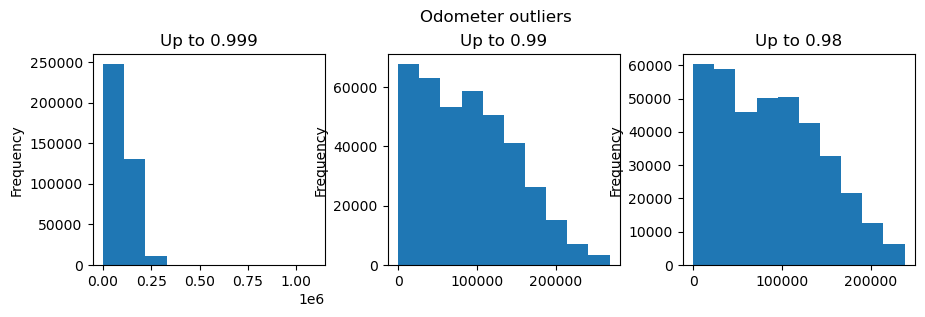

In [12]:
# 5. Odometer has some very high values, in millions of miles. Let's throw out some outliers.
thresholds = [0.999, 0.99, 0.98]
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
fig.suptitle('Odometer outliers')
fig.tight_layout()

for i, p in enumerate(thresholds):
    df_clean.odometer[df_clean.odometer < df_clean.odometer.quantile(p)].plot(kind='hist', ax=ax[i])
    ax[i].set_title(f'Up to {p}')

before = df_clean.shape[0]
df_clean = df_clean[df_clean['odometer'] < 240000]  # ~98th quantile
after = df_clean.shape[0]
print(f'Odometer outliers discarded: {before - after}. Retained {after}')

Text(0.5, 1.0, 'Price vs Odometer')

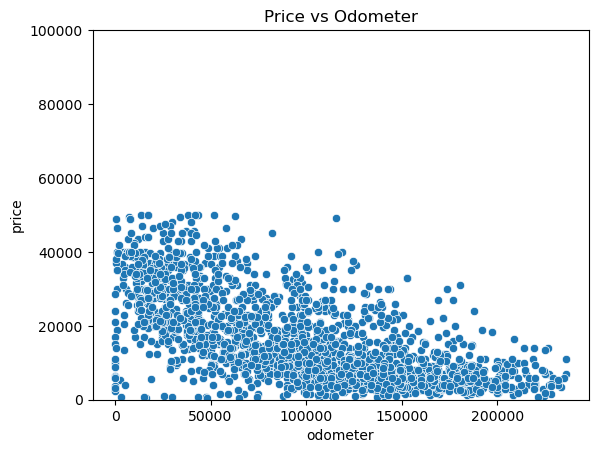

In [ ]:
fig = sns.scatterplot(df_clean.sample(1000), x='odometer', y='price')
fig.set_ylim(0, 100000)
fig.set_title('Price vs Odometer')

Text(0.5, 1.0, 'Price vs Year - pre-filter')

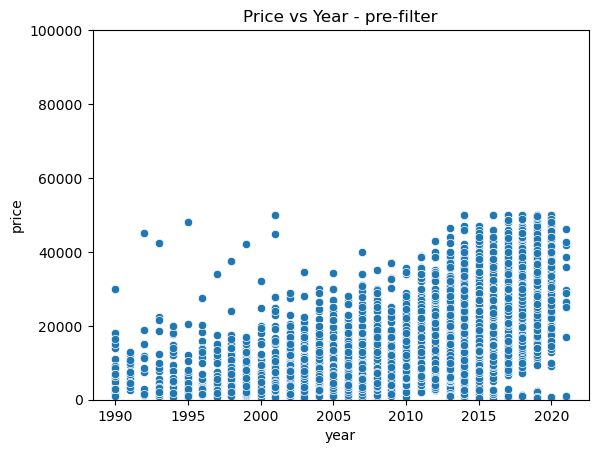

In [128]:
fig = sns.scatterplot(df_clean.sample(10000), x='year', y='price')
fig.set_ylim(0, 100000)
fig.set_title('Price vs Year - pre-filter')

Text(0.5, 1.0, 'Price vs Age - after age filter')

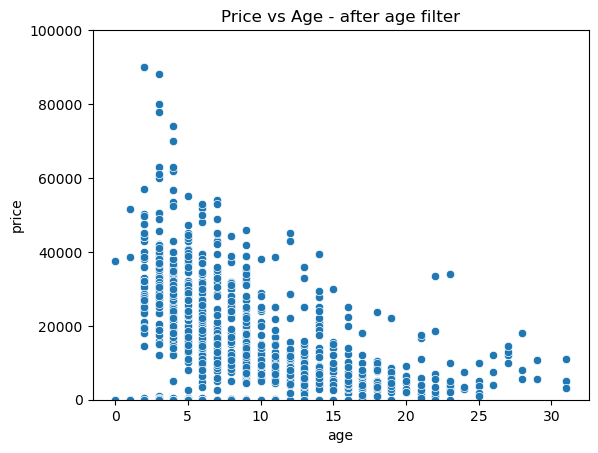

In [15]:
# Observation: prices get weird at years older than about 1990.

# 6. Remove old cars, as they complicate the trend, and create an age column
df_clean = df_clean[df_clean.year >= 1990]
df_clean['age'] = df_clean.year.max() - df_clean.year

fig = sns.scatterplot(df_clean.sample(1000), x='age', y='price')
fig.set_ylim(0, 100000)
fig.set_title('Price vs Age - after age filter')

In [16]:
# 7. Prices: Remove outliers and log transform.
df_clean = df_clean[(df_clean.price > 500) & (df_clean.price < 50000)]
df_clean['log_price'] = np.log(df_clean.price)

In [17]:
df_clean.log_price.describe()

count    326740.000000
mean          9.529041
std           0.832678
min           6.216606
25%           8.985946
50%           9.679531
75%          10.203222
max          10.819758
Name: log_price, dtype: float64

(0.0, 12.0)

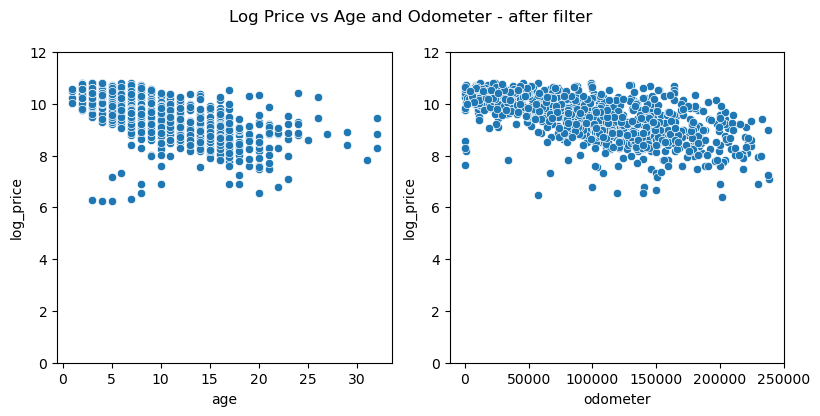

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Log Price vs Age and Odometer - after filter')
fig.tight_layout()

fig = sns.scatterplot(df_clean.sample(1000), x='age', y='log_price', ax=ax[0])
fig.set_ylim(0, 12)

fig = sns.scatterplot(df_clean.sample(1000), x='odometer', y='log_price', ax=ax[1])
fig.set_ylim(0, 12)


<Axes: xlabel='condition', ylabel='price'>

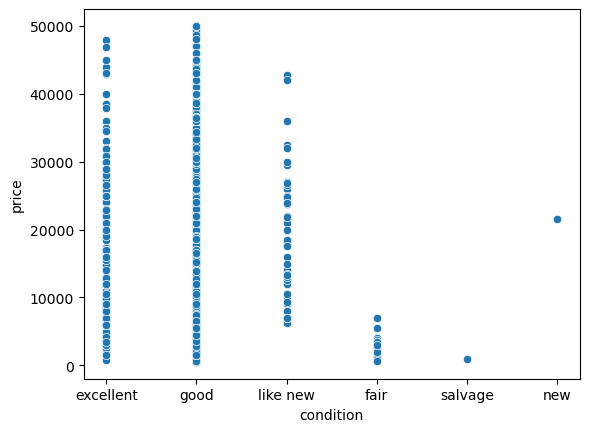

In [19]:
# Inspect condition vs price
sns.scatterplot(df_clean.sample(1000), x='condition', y='price')
# Observation: 'condition' has a turbulent relationship with price. It may carry little information for the model.

In [20]:
# 8. Cylinders to numerical
#    40% missing, but after much investigation and failure, it has been determined that 'model'
#     won't be retained, so the loss should cost little.
df_clean = df_clean[~df_clean['cylinders'].str.contains('other') & ~df_clean['cylinders'].isnull()]
df_clean['cylinders'] = pd.to_numeric(df_clean['cylinders'].str.replace(' cylinders', ''), errors='coerce')
df_clean = df_clean.dropna(subset=['cylinders'])


In [21]:
# 9. Drop the 8% not burning gas
df_clean = df_clean[df_clean['fuel'] == 'gas']

In [ ]:
# 10. Simplify 'manufacturer'. Either group the least popular into one category...
#     ... or drop them if not too many.
print(df_clean.manufacturer.value_counts()[:23].index)
#['ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'jeep', 'gmc',
# 'dodge', 'ram', 'bmw', 'subaru', 'mercedes-benz', 'hyundai', 'lexus',
# 'volkswagen', 'kia', 'chrysler', 'audi', 'acura', 'cadillac',
# 'infiniti', 'buick', 'mazda']

df_clean.manufacturer.value_counts()[:23].sum()
# This would keep 166629 out of 176184, or 94.3% of the data but remove almost half of the noise. Win.

top23 = df_clean.manufacturer.value_counts()[:23].index
df_clean = df_clean[df_clean.manufacturer.isin(top23)]

Index(['ford', 'chevrolet', 'toyota', 'honda', 'nissan', 'jeep', 'gmc',
       'dodge', 'ram', 'bmw', 'subaru', 'mercedes-benz', 'hyundai', 'lexus',
       'volkswagen', 'kia', 'chrysler', 'audi', 'acura', 'cadillac',
       'infiniti', 'buick', 'mazda'],
      dtype='object', name='manufacturer')


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

> Here follows a painful exploration of column transformers and their practical limitations.

In [35]:
df_clean['condition'].unique()

array(['good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

``` Python

# Utility for applying a transform on a DataFrame and getting a DataFrame out
def col_transform(df, x4m) -> pd.DataFrame:
    data_np = x4m.fit_transform(df)
    return pd.DataFrame(data_np, columns=x4m.get_feature_names_out())

# Data Set 1

# Ordinal encode 'condition'
# Normalize numeric and take their polynomial features
# One-Hot encode the rest
col_transformer = make_column_transformer(
    (OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (PolynomialFeatures(degree = 2), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(drop = 'if_binary', sparse_output=False), make_column_selector(dtype_include=object)),
    remainder='passthrough'
)

``` Python
# Experiment: Does a column selector for np.number pick up a column generated by previous OrdinalEncoder step?
col_transformer = make_column_transformer(
    (OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (PolynomialFeatures(degree = 2), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(drop = 'if_binary', sparse_output=False), make_column_selector(dtype_include=object)),
    remainder='passthrough'
)
test = col_transform(df_clean[['condition', 'odometer', 'year']], col_transformer)
# Result: No! Column transformation is done "in parallel". Transformation in series must use a Pipeline?


``` Python
# Experiment: How many features are produced by the cleaned data without any further pruning (389604, 16),
# when fed through the transformer?
test_df = col_transform(df_clean.sample(300000), col_transformer)

# Result:
    # 1000 samples:  10xx features
    # 5000 samples:  26xx features
    # 10000 samples: 38xx features
    # 100k samples: 12xxx features and 13 seconds to transform. That's very big.
    # 300k samples: 20xxx features and 1m 21s to transform.
# I need to consider throwing out redundant data, even if it includes golden nugggets, to make the data more manageable.
# Result after discarding

``` Python
# Data Set 2: Minimal features on large data set
# year, manufacturer, oe(condition), odometer, transmission, type, state

## First attempt to transform the data

transform_condition_ord = make_column_transformer(
    (OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]), ['condition']),
    remainder='passthrough'
)

transform_scaler = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    remainder='passthrough'
)

transform_poly = make_column_transformer(
    (PolynomialFeatures(degree = 2), make_column_selector(dtype_include=np.number)),
    remainder='passthrough'
)

transform_ohe = make_column_transformer(
    (OneHotEncoder(drop='if_binary', sparse_output=False), make_column_selector(dtype_include=object)),
    remainder='passthrough'
)

pipe2 = Pipeline([
    ('oe', transform_condition_ord),
    ('scaler', transform_scaler),
    ('poly', transform_poly),
    ('ohe', transform_ohe)#,
    #('model', LinearRegression())
])

Data2 = df_clean[['year', 'manufacturer', 'condition', 'odometer', 'transmission', 'type', 'state']]
#Data2_x = pipe2.fit_transform(Data2)
    # ValueError: make_column_selector can only be applied to pandas dataframes
    # It appears the output of each pipeline step is a np.ndarray instead of a dataframe.

## First transform attempt fails!
# Column transformers can't be serialized because their output is an ndarray, which has uniform type.
# The make_column_selector on the subsequent step requires a DataFrame, not an ndarray.
# Instead of the series approach, let's try a series-parallel approach by wrapping the transformers in pipelines...

``` Python
## Second attempt to transform the data series-parallel
ord_scale_pipe = Pipeline([
    ('oe', OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']])),
    ('scale', StandardScaler())
])

col_transformer2 = make_column_transformer(
    (ord_scale_pipe, ['condition']),
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (PolynomialFeatures(degree = 2), make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(drop = 'if_binary', sparse_output=False), make_column_selector(dtype_include=object)),
    remainder='passthrough'
)

## This does not combine the ordinal encoded 'condition' with the PolynomialFeatures!
# Where to go from here? ...
# 1. Transform the 'condition' column beforehand, outside the pipeline.
# 2. Give up on serial transformation, and settle for one-hot encoded 'condition'.


``` Python
## Third attempt: Do it manually.
#       One day more... Another day, another destiny.

Data2 = df_clean[['year', 'manufacturer', 'condition', 'odometer', 'transmission', 'type', 'state', 'price']]

#tmp = col_transform(Data2, transform_condition_ord)
#tmp = col_transform(Data2, transform_scaler)
#tmp = col_transform(tmp, transform_poly)
# Unfortunately, the column names are chained together, e.g. "remainder__remainder__remainder__manufacturer" ...
# Let's get around that by just doing the whole thing very, very manually.
# I would love to know how to use column transformers for this common use case, but they disappoint miserably.

Data2[['condition']] = OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]).fit_transform(Data2[['condition']])

numerical_predictors = ['year', 'odometer', 'condition']
Data2[numerical_predictors] = StandardScaler().fit_transform(Data2[numerical_predictors])


In [32]:
# The culmination of the above pain is the following two choices for dataset representations
def build_dataset(df, id) -> tuple[pd.DataFrame, pd.Series]:
    """ Returns (X, y) predictors and labels"""
    
    if id == 0:
        # Numerical data only for proof of concept / baseline run. Low predictive value
        cols = ['age', 'odometer', 'cylinders', 'log_price']
        data = df[cols]
        
    if id == 1:
        # The theory for Data Set 1 is brute force: capture the vehicle features primarily by model and age.
        # This one ran into memory allocation issues during training, so it should probably be narrowed down
        # to a specific manufacturer to limit the number of one-hot model features.
        cols = ['age', 'odometer', 'model', 'condition', 'state', 'cylinders', 'log_price']
        data = df[cols]

    elif id == 2:
        # The theory for Data Set 2 is generalized: capture features primarily by manufacturer and type
        cols = ['age', 'odometer', 'cylinders', 'manufacturer', 'condition' 'transmission', 'type', 'state', 'log_price']
        data = df[cols]
        data[['condition']] = OrdinalEncoder(categories = [['salvage', 'fair', 'good', 'excellent', 'like new', 'new']]
                                             ).fit_transform(data[['condition']])

        numerical_predictors = ['age', 'odometer', 'cylinders', 'condition']
        data[numerical_predictors] = StandardScaler().fit_transform(data[numerical_predictors])

    elif id == 3:
        # The theory for Data Set 3 is to use all numerical features and minimal one-hot features
        cols = ['age', 'odometer', 'cylinders', 'manufacturer', 'condition', 'type', 'log_price']
        data = df[cols]

        numerical_predictors = ['age', 'odometer', 'cylinders']
        data[numerical_predictors] = StandardScaler().fit_transform(data[numerical_predictors])

    return data.drop(columns='log_price'), data.log_price


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Grading criteria:
* Use of multiple regression models
* Cross-validation of models
* Grid search hyperparameters
* Appropriate interpretation of coefficients in models
* Appropriate interpretation of evaluation metric
* Clear identification of evaluation metric
* Clear rationale for use of given evaluation metric

In [18]:
# If 'model' is taken to include the training, then it includes source data. I would like to see the results of several training variations:
# - Numeric only
# - df_clean: sanitized full set
# - df_sub1: sanitized full set, drop region
# - sanitized, drop most things including 'model'. Primarily identify vehicle by 'manufacturer' and 'type'.
# Let's see if I have time to do all that ...

# Firstly, fit multiple model types on the same set, then see if I have time to run a model on a different representation of the data.

In [105]:
def build_model(id):

    transform_poly_ohe = make_column_transformer(
        (PolynomialFeatures(degree=2, include_bias=False), make_column_selector(dtype_include=np.number)),
        (OneHotEncoder(drop = 'if_binary', sparse_output=False), make_column_selector(dtype_include=object)),
        remainder='passthrough'
    )

    model = None

    if id == 0:
        # Baseline/reference simple linear regression model
        model = Pipeline([
            ('x4m', transform_poly_ohe),
            ('model', LinearRegression())
        ])

    elif id == 1:
        # Sequential Feature Selector with Ridge regression

        pipe = Pipeline([
            ('x4m', transform_poly_ohe),
            ('sfs', SequentialFeatureSelector(LinearRegression())),
            ('model', Ridge())
        ])

        param_dict = {'sfs__n_features_to_select': [10, 16, 22, 28], 'model__alpha': [0.1, 1, 10]}
            # Does it make sense to grid search n_features?
        #param_dict = {'model__alpha': [0.1, 1, 10]}

        model = GridSearchCV(pipe, param_dict, cv=3)

    elif id == 2:
        # Lasso
        pipe = Pipeline([
            ('x4m', transform_poly_ohe),
            ('model', Lasso(alpha=1, random_state=24601))
        ])
        
        param_dict = {'model__alpha': [0.01, 0.04, 0.1, 0.4]}
        model = GridSearchCV(pipe, param_dict, cv=3)
        
    return model

#### Model 0: Simple linear regression
Simple linear regression on numerical data. This is not expected to perform well, but to establish a baseline for better models to beat.

In [ ]:
# Model 0: Perform simple Linear Regression on one-hot and poly as a benchmark

data_id = 3     # Try 0 and 3
X, y = build_dataset(df_clean, data_id)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24601)    # I'm Jean Val Jean

model0 = build_model(0)

train_rmse, test_rmse = model_fit_evaluate(model0, X_train, X_test, y_train, y_test, report=True)

record_results('Simple Linear', data_id, train_rmse, test_rmse)
#  MSE (train/test): 12086123.8, 9793398.9      Data set 2, only float columns, before further data processing on 6/28 7pm
#  MSE (train/test): 11004.3, 11008.5           Data set 2, all columns, in 2.4 s, before further data processing on 6/28 7pm
#  For Data Set 1: MemoryError: Unable to allocate 37.5 GiB for an array with shape (272454, 18487) and data type float64
#  MSE (train/test): 0.504, 0.503 Data set 2 after further data processing on 6/28 7pm
#  MSE (train/test): 0.599, 0.599 Data set 0 (numerical only)
#  MSE (train/test): 0.488, 0.488 Data set 0 after more cleaning (6/28 10pm), first git commit

  MSE (train/test): 0.440, 0.441


In [85]:
coef = model0.named_steps['model'].coef_
names = model0.named_steps['x4m'].get_feature_names_out()

model0_weights = pd.DataFrame({'feature': names, 'coef': coef})
model0_weights['coef_mag'] = model0_weights['coef'].abs()
model0_weights.sort_values(by='coef_mag', ascending=False, inplace=True)

# Observation: The one-hot encoded weights need to be viewed separately from the linear weights.

onehot_features = model0_weights['feature'].str.contains('onehot')
onehot_weights = model0_weights[onehot_features]
scalar_weights = model0_weights[~onehot_features]   # Five weights > 250
onehot_weights

# Observation: The scalar weights look well-behaved, but the one-hot weights are practically infinite in magnitude!
# Tentative Conclusion: The one-hot data behaves like outliers, and the L2 error of Linear Regression is thrown off
# so much that the one-hot are unusable ???

,feature,coef,coef_mag
37,onehotencoder__condition_salvage,-0.559815,0.559815
33,onehotencoder__condition_fair,-0.420911,0.420911
45,onehotencoder__type_offroad,0.417906,0.417906
24,onehotencoder__manufacturer_lexus,0.322627,0.322627
44,onehotencoder__type_mini-van,-0.281474,0.281474
32,onehotencoder__condition_excellent,0.277763,0.277763
34,onehotencoder__condition_good,0.251732,0.251732
10,onehotencoder__manufacturer_audi,0.250769,0.250769
15,onehotencoder__manufacturer_chrysler,-0.249290,0.249290
43,onehotencoder__type_hatchback,-0.249185,0.249185


In [42]:
scalar_weights

,feature,coef,coef_mag
0,polynomialfeatures__age,-0.500732,0.500732
2,polynomialfeatures__cylinders,0.239802,0.239802
1,polynomialfeatures__odometer,-0.203175,0.203175
3,polynomialfeatures__age^2,0.073165,0.073165
4,polynomialfeatures__age odometer,-0.043430,0.043430
6,polynomialfeatures__odometer^2,-0.019197,0.019197
5,polynomialfeatures__age cylinders,0.007321,0.007321
7,polynomialfeatures__odometer cylinders,0.007255,0.007255
8,polynomialfeatures__cylinders^2,0.004377,0.004377


In [ ]:
# Observation: The two most impactful features are 'age' (-0.50) and being "salvage" (-0.56).
#   Those two conditions go together like peas and carrots.

#### Model 1: Ridge regression with sequential feature selection and grid search.
This model is trained on Data Set 2 (Cars identified by make)

In [ ]:
# Model 1: Linear Regression with Sequential Feature Selection. Grid Search on number of selected features.

data_id = 3
X, y = build_dataset(df_clean, data_id)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24601)

if False:
    col_transformer = make_column_transformer(
        (PolynomialFeatures(degree=2, include_bias=False), make_column_selector(dtype_include=np.number)),
        (OneHotEncoder(drop = 'if_binary', sparse_output=False), make_column_selector(dtype_include=object)),
        remainder='passthrough'
    )

    m1_pipe = Pipeline([
        ('x4m', col_transformer),
        ('sfs', SequentialFeatureSelector(LinearRegression())),
        ('model', Ridge())
    ])

    param_dict = {'sfs__n_features_to_select': [5, 7, 9, 11], 'model__alpha': [0.1, 1, 10]}

    grid1 = GridSearchCV(m1_pipe, param_dict, cv=2).fit(X_train, y_train)
else:
    model1 = build_model(1)

    model1.fit(X_train, y_train)

# Outcomes:
#   4m: features_to_select = [5] (only one), model = LinearRegression()
#  75m: param_dict = {'sfs__n_features_to_select': [5, 7, 9, 11], 'model__alpha': [0.1, 1, 10]}
        # Winner: features=9, alpha=10                    ^                                ^^
#  51m: param_dict = {'sfs__n_features_to_select': [10, 16, 22, 28], 'model__alpha': [0.1, 1, 10]}
#       # Winner: features=28, alpha=0.1                        ^^                    ^^^

In [ ]:
# Examine results of Model 1 Grid Search
train_rmse_1, test_rmse_1 = model_fit_evaluate(model1.best_estimator_, X_train, X_test, y_train, y_test, fit=False)
# TODO: Verify whether the model needs to be refit                                                        ^^

record_results('Model 1 - LR SFS Ridge Grid', data_id, train_rmse_1, test_rmse_1)

  MSE (train/test): 0.442, 0.445


In [61]:
print('Grid Search best estimator parameters: ' + str(model1.best_params_))
model1.scoring

Grid Search best estimator parameters: {'model__alpha': 0.1, 'sfs__n_features_to_select': 28}


##### Explore Model 1 training result

In [62]:
model1.best_estimator_

Pipeline(steps=[('x4m',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FB69DE6D80>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FB624E60F0>)])),
                ('sfs',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=28)),
                ('model', Ridge(alpha=0.1))])

In [ ]:
sfs = model1.best_estimator_.named_steps['sfs']
x4m = model1.best_estimator_.named_steps['x4m']
model1_weights = pd.DataFrame(zip(x4m.get_feature_names_out()[sfs.get_support()], est.coef_), columns=['feature', 'coef'])
model1_weights['coef_mag'] = model1_weights.coef.abs()
model1_weights.sort_values(by='coef_mag', ascending=False)
model1_weights

# Observation: The first 10 highest-weighted coefficients in model 1 are very comparable to those of model 0.
# 

,feature,coef,coef_mag
0,polynomialfeatures__age,-0.493739,0.493739
1,polynomialfeatures__odometer,-0.205614,0.205614
2,polynomialfeatures__cylinders,0.245598,0.245598
3,polynomialfeatures__age^2,0.073841,0.073841
4,polynomialfeatures__age odometer,-0.058291,0.058291
5,onehotencoder__manufacturer_acura,0.203501,0.203501
6,onehotencoder__manufacturer_audi,0.355192,0.355192
7,onehotencoder__manufacturer_bmw,0.247464,0.247464
8,onehotencoder__manufacturer_chrysler,-0.150473,0.150473
9,onehotencoder__manufacturer_dodge,-0.108682,0.108682


#### Model 2: Lasso Regression

In [111]:
data_id = 3
X, y = build_dataset(df_clean, data_id)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24601)

model2 = build_model(2)

model2.fit(X_train, y_train)
train_rmse, test_rmse = model_fit_evaluate(model2.best_estimator_, X_train, X_test, y_train, y_test)

  MSE (train/test): 0.475, 0.477


In [107]:
model2.best_params_

{'model__alpha': 0.01}

In [112]:
record_results('Model 2 - Lasso Grid alpha=0.01', data_id, train_rmse, test_rmse)

In [136]:
model_rmse_df

,model_name,data_id,train_rmse,test_rmse
0,Model 0 - Simple LR,0,0.488397,0.488250
1,Model 0 - Simple LR,3,0.440344,0.441109
2,Model 1 - LR SFS Ridge Grid,3,0.442190,0.445027
4,Model 2 - Lasso Grid alpha=0.01,3,0.475213,0.477031


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [115]:
model_rmse_df.iloc[1,0] = 'Model 0 - Simple LR'

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Future Work

Examine data for which the `size` was provided, and see how much variance it explains.